## Avaliação em holdouts - LastFM


Note: namepaths is deprecated!

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData, getBucketsHoldouts
from plot_utils import lineplot_recallxholdout, recall_heatmap
from dataset_evaluation_utils import *
from recommenders_implicit import ISGD, RAISGD, RSISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateHoldouts, EvaluateAndStore, EvalPrequential # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout

import itertools

from datetime import datetime
import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
## BWT FWT

ACC, BWT, e FWT - Lopez-Paz e Ranzato GEM

In [3]:
def avg_recall(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    return np.mean( np.diag(results_matrix) )

def compute_BWT_lopes_ranzato(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    BWT = []
    n_checkpoints = results_matrix.shape[0]
    for T in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        Rti = results_matrix.iloc[T, 0:T] # get models performances' on previous holdouts
        Rii = np.diag(results_matrix)[0:T] # get models performances' on their closest holdouts (diagonal)
        E = sum( Rti - Rii ) # future models performances' - performances' of models closest to holdouts (diagonal)
        BWT.append( E/T ) # store average BWT for model
    return BWT, np.mean( BWT ) # return BWT and average BWT for all models

def compute_BWT_rodrigues(results_matrix): # Díaz-Rodriguez et al. 2018
    diff = []
    n_checkpoints = results_matrix.shape[0]
    for i in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        for j in range(i):
            Rij = results_matrix.iloc[i,j] # get models performances' on previous holdouts
            Rjj = results_matrix.iloc[j,j] # get models performances' on their closest holdouts (diagonal)
            # print(Rij, Rjj)
            diff.append( Rij - Rjj ) # future models performances' - performances' of models closest to holdouts (diagonal)
            # print(diff)
    BWT = sum(diff) / ( n_checkpoints*(n_checkpoints-1) / 2 ) # store average BWT for model
    return BWT, diff # return BWT and average BWT for all models

def compute_FWT_rodrigues(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)


def grid_search(model, stream, random_seed = 10, interleaved=10):    
    num_factors = [50, 100, 150, 200]
    num_iter = [1, 2, 5, 8]
    learn_rate = [0.01, 0.05, 0.1, 0.25, 0.5]
    regularization = [0.01, 0.05, 0.1, 0.25, 0.5]
    num_nodes = [1, 2, 4, 8, 16]
    grid = [num_factors, num_iter, learn_rate, regularization, num_nodes]
    grid = list(itertools.product(*grid))
    results = []
    for i, hp in enumerate(grid):
        print(((i*100)/len(grid)), '%')
        empty_stream = ImplicitData([], [])
        nf, ni, lr, reg, nn = hp
        m = model(empty_stream, nf, ni, lr, reg, reg, random_seed)
        e = EvalPrequential(m, stream, metrics = ["Recall@N"])
        result = e.Evaluate(start_eval=0, count=stream.size, interleaved=interleaved)
        results.append( np.mean(result['Recall@N']) )
    return grid, results  

In [4]:
def get_namepaths(sample_year_month,
                  interval_type,
                  dump_filename,
                  use_data_unique_users,
                  to_grid_search,
                  num_factors,
                  num_iter,
                  learn_rate,
                  regularization,
                  random_seed):
    
    sample_year_month_start = sample_year_month[0][0]
    sample_year_month_end = sample_year_month[1][0]
    sample_str = str(sample_year_month_start)+'_until_'+str(sample_year_month_end)


    dataset_name = 'sample_'+sample_str+'_lastfm'
    user_col = 'user_id'
    item_col = 'artist_id'

    output_path = 'output/'+dump_filename+'/'

    data_path = output_path+''+dataset_name+'.joblib'

    frequent_users_path = output_path+'sample_'+sample_str+'_frequent_users.joblib' 


    if interval_type == 'Q':
        intervals_path = output_path+'sample_'+sample_str+'_trimestres.joblib'
        bucket_freq =  'quarterly'
    elif interval_type == 'S':
        intervals_path = output_path+'sample_'+sample_str+'_semestres.joblib'
        bucket_freq = 'semesterly'
    else:
        # interval_type == 'M'
        intervals_path = None
        bucket_freq = 'monthly'


    buckets_path = output_path+'sample_'+sample_str+'_'+bucket_freq+'_buckets.joblib'
    holdouts_path = output_path+'sample_'+sample_str+'_'+bucket_freq+'_holdouts.joblib'

    results_matrix_path = output_path+''+dataset_name+' '+bucket_freq+'_bucket ISGD results.joblib'

    recall_heatmap_title = 'Recall@20 for ISGD checkpoints across Holdouts ('+sample_str+'_'+bucket_freq+') - LastFM'
    recall_heatmap_path = 'images/heatmaps/'+dump_filename+'/'+dataset_name+' '+bucket_freq+'_bucket ISGD heatmap.png'

    incrementalTraining_time_record_path = output_path+''+dataset_name+' '+bucket_freq+'_bucket ISGD training time.joblib'
    evaluateHoldouts_time_record_path =  output_path+''+dataset_name+' '+bucket_freq+'_bucket ISGD eval time.joblib'

    return {'sample_str': sample_str, 
            'dataset_name': dataset_name,
            'user_col': user_col, 
            'item_col': item_col,
            'output_path': output_path, 
            'data_path': data_path,
            'use_data_unique_users': use_data_unique_users,
            'frequent_users_path':frequent_users_path,
            'to_grid_search':to_grid_search,
            'num_factors': num_factors,
            'num_iter': num_iter,
            'learn_rate': learn_rate,
            'regularization': regularization,
            'random_seed': random_seed,
            'interval_type': interval_type,
            'intervals_path': intervals_path,
            'bucket_freq': bucket_freq,
            'buckets_path': buckets_path,
            'holdouts_path': holdouts_path,
            'results_matrix_path': results_matrix_path,
            'recall_heatmap_title': recall_heatmap_title,
            'recall_heatmap_path': recall_heatmap_path,
            'incrementalTraining_time_record_path': incrementalTraining_time_record_path,
            'evaluateHoldouts_time_record_path': evaluateHoldouts_time_record_path}

def load_data_print_info(data_path):
    # data = pd.read_csv(data_path)
    data = joblib.load(data_path)
    data.columns = ['user_id', 'item_id', 'date', 'timestamp']

    print('data.shape', data.shape)
    print('number of users', data.user_id.nunique())
    print('number of items', data.item_id.nunique())
    print('number of duplicated user-item interactions', data[['user_id', 'item_id']].duplicated().sum())


    print('\n',data.head())


    # convert timestamp
    if data['date'].dtype is str:
        data['date'] = data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))


    interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
    interactions_per_month.name = 'count'
    interactions_per_month=interactions_per_month.reset_index()
    _ = interactions_per_month.copy()
    _['date'] = _['date'].dt.date
    _.groupby('date').sum().plot(kind='bar')
    plt.title('interactions per month');

    return data


def run_evaluate(data,
                 user_col,
                 item_col, 
                 interval_type, 
                 intervals_path, 
                 use_data_unique_users,
                 frequent_users_path,
                 buckets_path,
                 holdouts_path,
                 to_grid_search,
                 num_factors,
                 num_iter,
                 learn_rate,
                 regularization,
                 random_seed,
                 results_matrix_path,
                 recall_heatmap_title,
                 recall_heatmap_path,
                 incrementalTraining_time_record_path,
                 evaluateHoldouts_time_record_path):
    '''
    
        interval_type: string | M, Q, S

    '''

    
    frequent_users = joblib.load(frequent_users_path)
    frequent_users_idx = None

    if interval_type=='Q':
        frequent_users_idx = 1
        interval_type ='QS'
        intervals = joblib.load(intervals_path)

    elif interval_type=='S':
        frequent_users_idx = 2
        interval_type ='QS'
        intervals = joblib.load(intervals_path)
    else:
        # assumes monthly interval
        # interval_type = 'M'
        frequent_users_idx = 0 
        intervals = None   
        if use_data_unique_users:
            frequent_users = (data['user_id'].unique(), frequent_users[1], frequent_users[2])
        
        

    print('\nSTAGE -> getBucketsHoldouts')
    buckets, holdouts = getBucketsHoldouts( data = data,
                                            user_col = user_col,
                                            item_col = item_col,
                                            frequent_users = frequent_users[frequent_users_idx],
                                            interval_type = interval_type, # if interval_type=='M' else 'QS',
                                            intervals = intervals, 
                                            cold_start_buckets = 0)
    

    joblib.dump(buckets, buckets_path)
    joblib.dump(holdouts, holdouts_path)
    
    print('\nBucket size, number of users, number of items\n', [(b.size, len(b.userset), len(b.itemset)) for b in buckets])
    print('Holdouts size, number of users, number of items\n', [(b.size, len(b.userset), len(b.itemset)) for b in holdouts])


    print('\n\nSTAGE -> to_grid_search')
    if to_grid_search:
        prop = 0.05 
        hp_sample = data.iloc[:round( data.shape[0]*prop )]
        stream = ImplicitData(hp_sample[user_col], hp_sample[item_col]) 
        grid, results = grid_search(model = ISGD, 
                                    stream = stream, 
                                    random_seed = random_seed, 
                                    interleaved = 100 )
        num_factors, num_iter, learn_rate, regularization, _ = grid[ np.argmax( results ) ]

    print('num_factors, num_iter, learn_rate, regularization\n', (num_factors, num_iter, learn_rate, regularization))

    print('\n\nSTAGE -> ISGD model')
    empty_stream = ImplicitData([], [])
    model = ISGD(empty_stream, 
                num_factors, 
                num_iter, 
                learn_rate = learn_rate,
                u_regularization = regularization,
                i_regularization = regularization,
                random_seed = random_seed)
    


    print('\n\nSTAGE -> EvaluateHoldouts')
    eval = EvaluateHoldouts(model = model,
                            buckets = buckets,
                            holdouts = holdouts)
    
    eval.Train_Evaluate(N_recommendations=20, exclude_known_items=True, default_user='none')

    rm = eval.results_matrix
    rm_df = pd.DataFrame(rm)
    rm_df.to_csv(results_matrix_path, index=False)
    print(rm_df)

    recall_heatmap( rm_df,
                    round_point = 4,
                    title = recall_heatmap_title,
                    filepath = recall_heatmap_path) 
    

    print('\n\nstage -> metrics')    
    arecall = avg_recall(rm_df)
    BWT_lr, meanBWT_lr = compute_BWT_lopes_ranzato(rm_df)
    BWT_r, meanBWT_r = compute_BWT_rodrigues(rm_df)
    FWT_r = compute_FWT_rodrigues(rm_df)

    print('avg recall', arecall.round(6))
    print('BWT (v. Lopez-Paz e Ranzato GEM 2017), meanBWT', (BWT_lr, meanBWT_lr))
    print('BWT (v. Díaz-Rodriguez et al. 2018), meanBWT', (BWT_r, meanBWT_r))
    print('FWT', FWT_r.round(6))

    joblib.dump(eval.IncrementalTraining_time_record, incrementalTraining_time_record_path)
    joblib.dump(eval.EvaluateHoldouts_time_record, evaluateHoldouts_time_record_path)


    return rm_df, arecall, (BWT_lr, meanBWT_lr), (BWT_r, meanBWT_r), FWT_r


def print_heatmap(results_matrix_path, recall_heatmap_title, filepath=False):
    rm_df = pd.read_csv(results_matrix_path)
    recall_heatmap( rm_df,
                    round_point = 4,
                    title = recall_heatmap_title,
                    filepath = filepath) 


In [5]:
namepaths = get_namepaths(sample_year_month = [('2008-01', '%Y-%m'), ('2011-01', '%Y-%m')],
                          interval_type = 'S',
                          dump_filename ='lastfm_2k_dump',
                          use_data_unique_users = False,
                          to_grid_search = False,
                          num_factors = 100,
                          num_iter = 6,
                          learn_rate = 0.1,
                          regularization = 0.1,
                          random_seed = 10)
namepaths

{'sample_str': '2008-01_until_2011-01',
 'dataset_name': 'sample_2008-01_until_2011-01_lastfm',
 'user_col': 'user_id',
 'item_col': 'artist_id',
 'output_path': 'output/lastfm_2k_dump/',
 'data_path': 'output/lastfm_2k_dump/sample_2008-01_until_2011-01_lastfm.joblib',
 'use_data_unique_users': False,
 'frequent_users_path': 'output/lastfm_2k_dump/sample_2008-01_until_2011-01_frequent_users.joblib',
 'to_grid_search': False,
 'num_factors': 100,
 'num_iter': 6,
 'learn_rate': 0.1,
 'regularization': 0.1,
 'random_seed': 10,
 'interval_type': 'S',
 'intervals_path': 'output/lastfm_2k_dump/sample_2008-01_until_2011-01_semestres.joblib',
 'bucket_freq': 'semesterly',
 'buckets_path': 'output/lastfm_2k_dump/sample_2008-01_until_2011-01_semesterly_buckets.joblib',
 'holdouts_path': 'output/lastfm_2k_dump/sample_2008-01_until_2011-01_semesterly_holdouts.joblib',
 'results_matrix_path': 'output/lastfm_2k_dump/sample_2008-01_until_2011-01_lastfm semesterly_bucket ISGD results.joblib',
 'recall

data.shape (22139, 4)
number of users 140
number of items 7669
number of duplicated user-item interactions 4128

       user_id  item_id       date   timestamp
2297       25       67 2008-01-01  1199145600
2298       25      155 2009-11-01  1257033600
2299       25      155 2008-01-01  1199145600
2300       25      157 2009-11-01  1257033600
2302       25      157 2009-06-01  1243814400


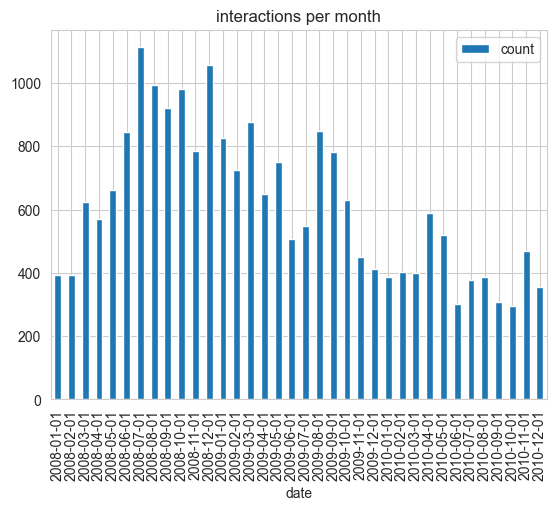

In [6]:
data = load_data_print_info(namepaths['data_path'])


STAGE -> getBucketsHoldouts
Creating buckets. . .
Creating holdouts. . .
Cleaning holdouts. . .
common interactions between holdout 1 and all buckets: 11
common interactions between holdout 2 and all buckets: 23
common interactions between holdout 3 and all buckets: 18
common interactions between holdout 4 and all buckets: 25
common interactions between holdout 5 and all buckets: 24
common interactions between holdout 6 and all buckets: 18
Converting to ImplicitData. . .
Done!

Bucket size, number of users, number of items
 [(3403, 109, 2164), (5743, 130, 3240), (4217, 130, 2827), (3561, 120, 2594), (2491, 120, 1915), (2101, 96, 1675)]
Holdouts size, number of users, number of items
 [(86, 86, 81), (108, 108, 106), (117, 117, 116), (112, 112, 112), (109, 109, 107), (91, 91, 90)]


STAGE -> to_grid_search
num_factors, num_iter, learn_rate, regularization
 (100, 6, 0.1, 0.1)


STAGE -> ISGD model


STAGE -> EvaluateHoldouts
---------------------------------------------------------------

(          0         1         2    3         4         5
 0  0.000000  0.000000  0.000000  0.0  0.000000  0.000000
 1  0.000000  0.000000  0.000000  0.0  0.000000  0.010989
 2  0.000000  0.000000  0.008547  0.0  0.000000  0.021978
 3  0.011628  0.000000  0.008547  0.0  0.000000  0.021978
 4  0.000000  0.009259  0.008547  0.0  0.000000  0.010989
 5  0.000000  0.000000  0.008547  0.0  0.009174  0.010989,
 0.003256003256003256,
 ([0.0,
   0.0,
   0.003875968992248062,
   0.0023148148148148147,
   0.001834862385321101],
  0.0016051292384767954),
 (0.00200409854417393,
  [0.0,
   0.0,
   0.0,
   0.011627906976744186,
   0.0,
   0.0,
   0.0,
   0.009259259259259259,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.009174311926605505]),
 0.004395604395604396)

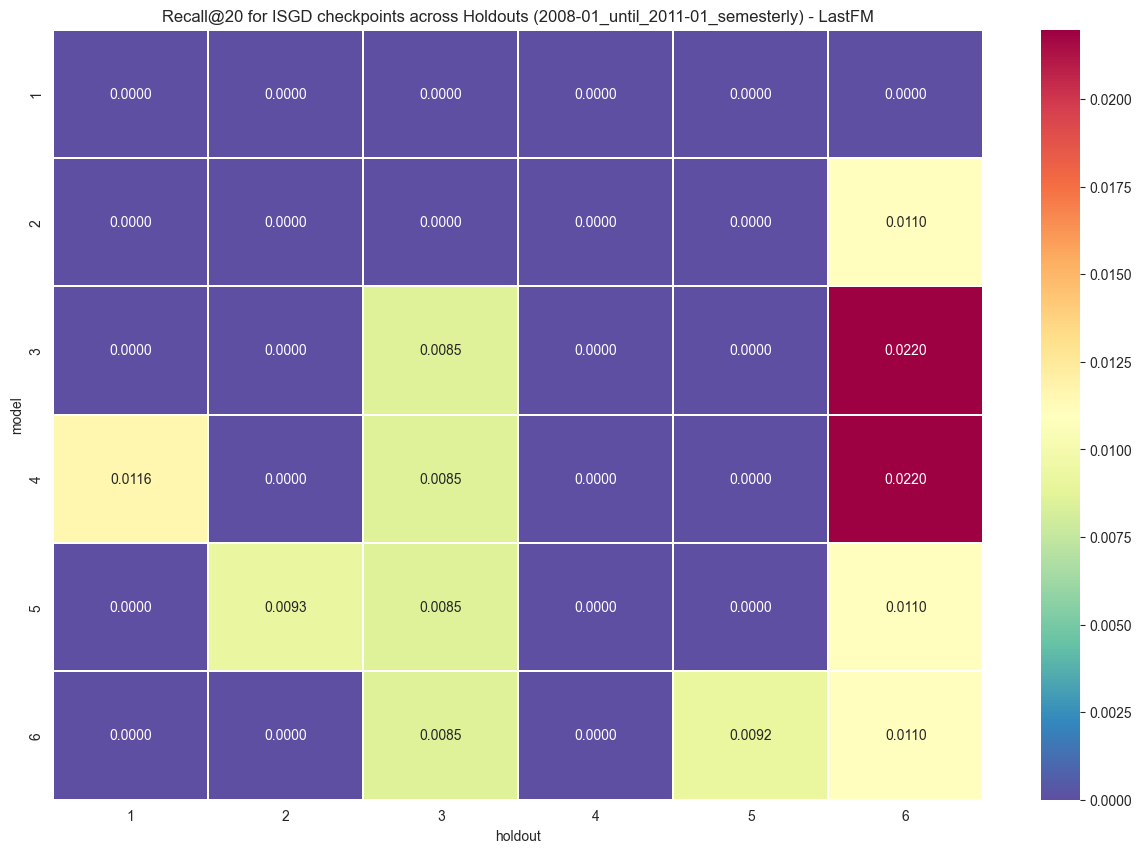

In [8]:
# data.columns = ['user_id', 'item_id', 'date']
data.columns = [namepaths['user_col'], namepaths['item_col'], 'date', 'timestamp']

run_evaluate(data = data,
             user_col = namepaths['user_col'],
             item_col = namepaths['item_col'],
             interval_type = namepaths['interval_type'],
             intervals_path = namepaths['intervals_path'],
             use_data_unique_users = namepaths['use_data_unique_users'],
             frequent_users_path = namepaths['frequent_users_path'],
             buckets_path = namepaths['buckets_path'],
             holdouts_path = namepaths['holdouts_path'],
             to_grid_search = namepaths['to_grid_search'],
             num_factors = namepaths['num_factors'],
             num_iter = namepaths['num_iter'],
             learn_rate = namepaths['learn_rate'],
             regularization = namepaths['regularization'],
             random_seed = namepaths['random_seed'],
             results_matrix_path = namepaths['results_matrix_path'],
             recall_heatmap_title = namepaths['recall_heatmap_title'],
             recall_heatmap_path = namepaths['recall_heatmap_path'],
             incrementalTraining_time_record_path = namepaths['incrementalTraining_time_record_path'],
             evaluateHoldouts_time_record_path = namepaths['evaluateHoldouts_time_record_path'])

# run_evaluate(data = data,
#              user_col = user_col,
#              item_col = item_col,
#              interval_type = interval_type,
#              intervals_path = intervals_path, 
#              use_data_unique_users = False,
#              frequent_users_path = frequent_users_path,
#              buckets_path = buckets_path,
#              holdouts_path = holdouts_path,
#              to_grid_search = to_grid_search,
#              random_seed = random_seed,
#              results_matrix_path = results_matrix_path,
#              recall_heatmap_title = recall_heatmap_title,
#              recall_heatmap_path = recall_heatmap_path,
#              incrementalTraining_time_record_path = incrementalTraining_time_record_path,
#              evaluateHoldouts_time_record_path = evaluateHoldouts_time_record_path)